# Purpose
* [Getting started example from the NumPyro docs](http://num.pyro.ai/en/latest/getting_started.html)

In [1]:
import numpy as np
import numpyro

import numpyro.distributions as dist

from jax import random
from numpyro.infer import MCMC, NUTS

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p numpy,numpyro,jax

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

numpy  : 1.20.3
numpyro: 0.7.2
jax    : 0.2.19

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 0730d5bb5177d05df9c76366f2f66065ef4e1817

Git branch: master



In [5]:
J = 8

y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])

sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [6]:
# Eight Schools example
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

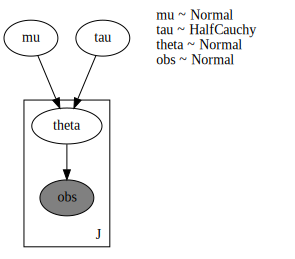

In [7]:
numpyro.render_model(eight_schools, model_args=(J,sigma, y), render_distributions=True)

In [8]:
nuts_kernel = NUTS(eight_schools)

In [9]:
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

In [10]:
rng_key = random.PRNGKey(0)

In [11]:
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

sample: 100%|██████████| 1500/1500 [00:03<00:00, 408.57it/s, 31 steps of size 3.72e-02. acc. prob=0.99] 


In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.34      3.09      4.19     -0.63      9.17    147.86      1.01
       tau      3.40      2.87      2.68      0.23      7.25     71.79      1.00
  theta[0]      5.84      5.04      5.19     -2.38     13.28    240.45      1.01
  theta[1]      4.88      4.36      4.70     -1.05     12.77    284.49      1.00
  theta[2]      3.91      5.36      4.05     -3.95     12.20    289.84      1.00
  theta[3]      4.58      4.65      4.30     -1.96     12.95    248.48      1.00
  theta[4]      3.65      4.27      3.74     -3.17     10.23    210.01      1.00
  theta[5]      3.95      4.47      4.05     -3.43     10.77    247.01      1.00
  theta[6]      6.25      4.88      5.36     -1.52     13.57    167.16      1.00
  theta[7]      4.79      4.98      4.38     -2.87     11.75    288.12      1.01

Number of divergences: 1


In [13]:
pe = mcmc.get_extra_fields()['potential_energy']

In [14]:
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))

Expected log joint density: -52.88


In [15]:
from numpyro.infer.reparam import TransformReparam

In [16]:
# Eight Schools example - Non-centered Reparametrization
def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        with numpyro.handlers.reparam(config={'theta': TransformReparam()}):
            theta = numpyro.sample('theta', dist.TransformedDistribution(dist.Normal(0., 1.), dist.transforms.AffineTransform(mu, tau)))
            numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

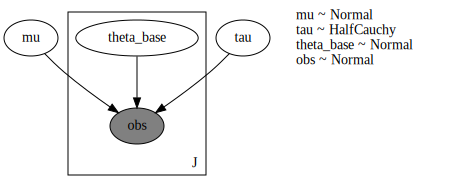

In [17]:
numpyro.render_model(eight_schools_noncentered, model_args=(J,sigma, y), render_distributions=True)

In [18]:
nuts_kernel = NUTS(eight_schools_noncentered)

In [19]:
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

In [20]:
rng_key = random.PRNGKey(0)

In [21]:
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

sample: 100%|██████████| 1500/1500 [00:03<00:00, 398.31it/s, 7 steps of size 5.70e-01. acc. prob=0.86]


In [22]:
mcmc.print_summary(exclude_deterministic=False)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.38      3.17      4.42     -0.64      9.79   1621.03      1.00
          tau      3.59      3.47      2.71      0.00      7.77    566.27      1.00
     theta[0]      6.23      5.44      5.63     -1.81     13.97    905.01      1.00
     theta[1]      4.78      4.66      4.65     -2.86     12.17   1391.34      1.00
     theta[2]      3.72      5.30      4.11     -4.03     11.69   1195.51      1.00
     theta[3]      4.63      4.73      4.62     -2.78     11.37   1247.63      1.00
     theta[4]      3.52      4.51      3.70     -3.43     10.35   1143.75      1.00
     theta[5]      4.05      4.82      4.13     -2.93     12.17   1147.91      1.00
     theta[6]      6.20      4.79      5.77     -1.44     13.38   1341.81      1.00
     theta[7]      4.56      5.09      4.40     -3.56     11.50    902.34      1.00
theta_base[0]      0.28      0.90      0.31     -1.11      1.82   1513.99  

In [23]:
pe = mcmc.get_extra_fields()['potential_energy']

In [24]:
# Compare with the earlier value
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))

Expected log joint density: -46.06


In [25]:
from numpyro.infer import Predictive

In [26]:
def new_school():
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    return numpyro.sample('obs', dist.Normal(mu, tau))

In [27]:
predictive = Predictive(new_school, mcmc.get_samples())

In [28]:
samples_predictive = predictive(random.PRNGKey(1))

In [29]:
print(np.mean(samples_predictive['obs']))

4.4789295


In [30]:
import arviz as az

In [31]:
ds = az.from_numpyro(mcmc)

In [32]:
ds.posterior

<xarray.Dataset>
Dimensions:           (chain: 1, draw: 1000, theta_dim_0: 8, theta_base_dim_0: 8)
Coordinates:
  * chain             (chain) int64 0
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * theta_dim_0       (theta_dim_0) int64 0 1 2 3 4 5 6 7
  * theta_base_dim_0  (theta_base_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    mu                (chain, draw) float32 2.172 1.644 1.199 ... 6.944 6.354
    tau               (chain, draw) float32 5.231 4.505 2.593 ... 2.414 11.4
    theta             (chain, draw, theta_dim_0) float32 -0.004542 6.55 ... 3.99
    theta_base        (chain, draw, theta_base_dim_0) float32 -0.416 ... -0.2074
Attributes:
    created_at:                 2021-08-29T23:54:44.225521
    arviz_version:              0.11.2
    inference_library:          numpyro
    inference_library_version:  0.7.2

array([[<AxesSubplot:ylabel='theta\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta\n3'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta\n4'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta\n5'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta\n6'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='theta\n0', ylabel='theta\n7'>,
        <AxesSubplot:xlabel='theta\n1'>, <AxesSubplot:xlabel='th

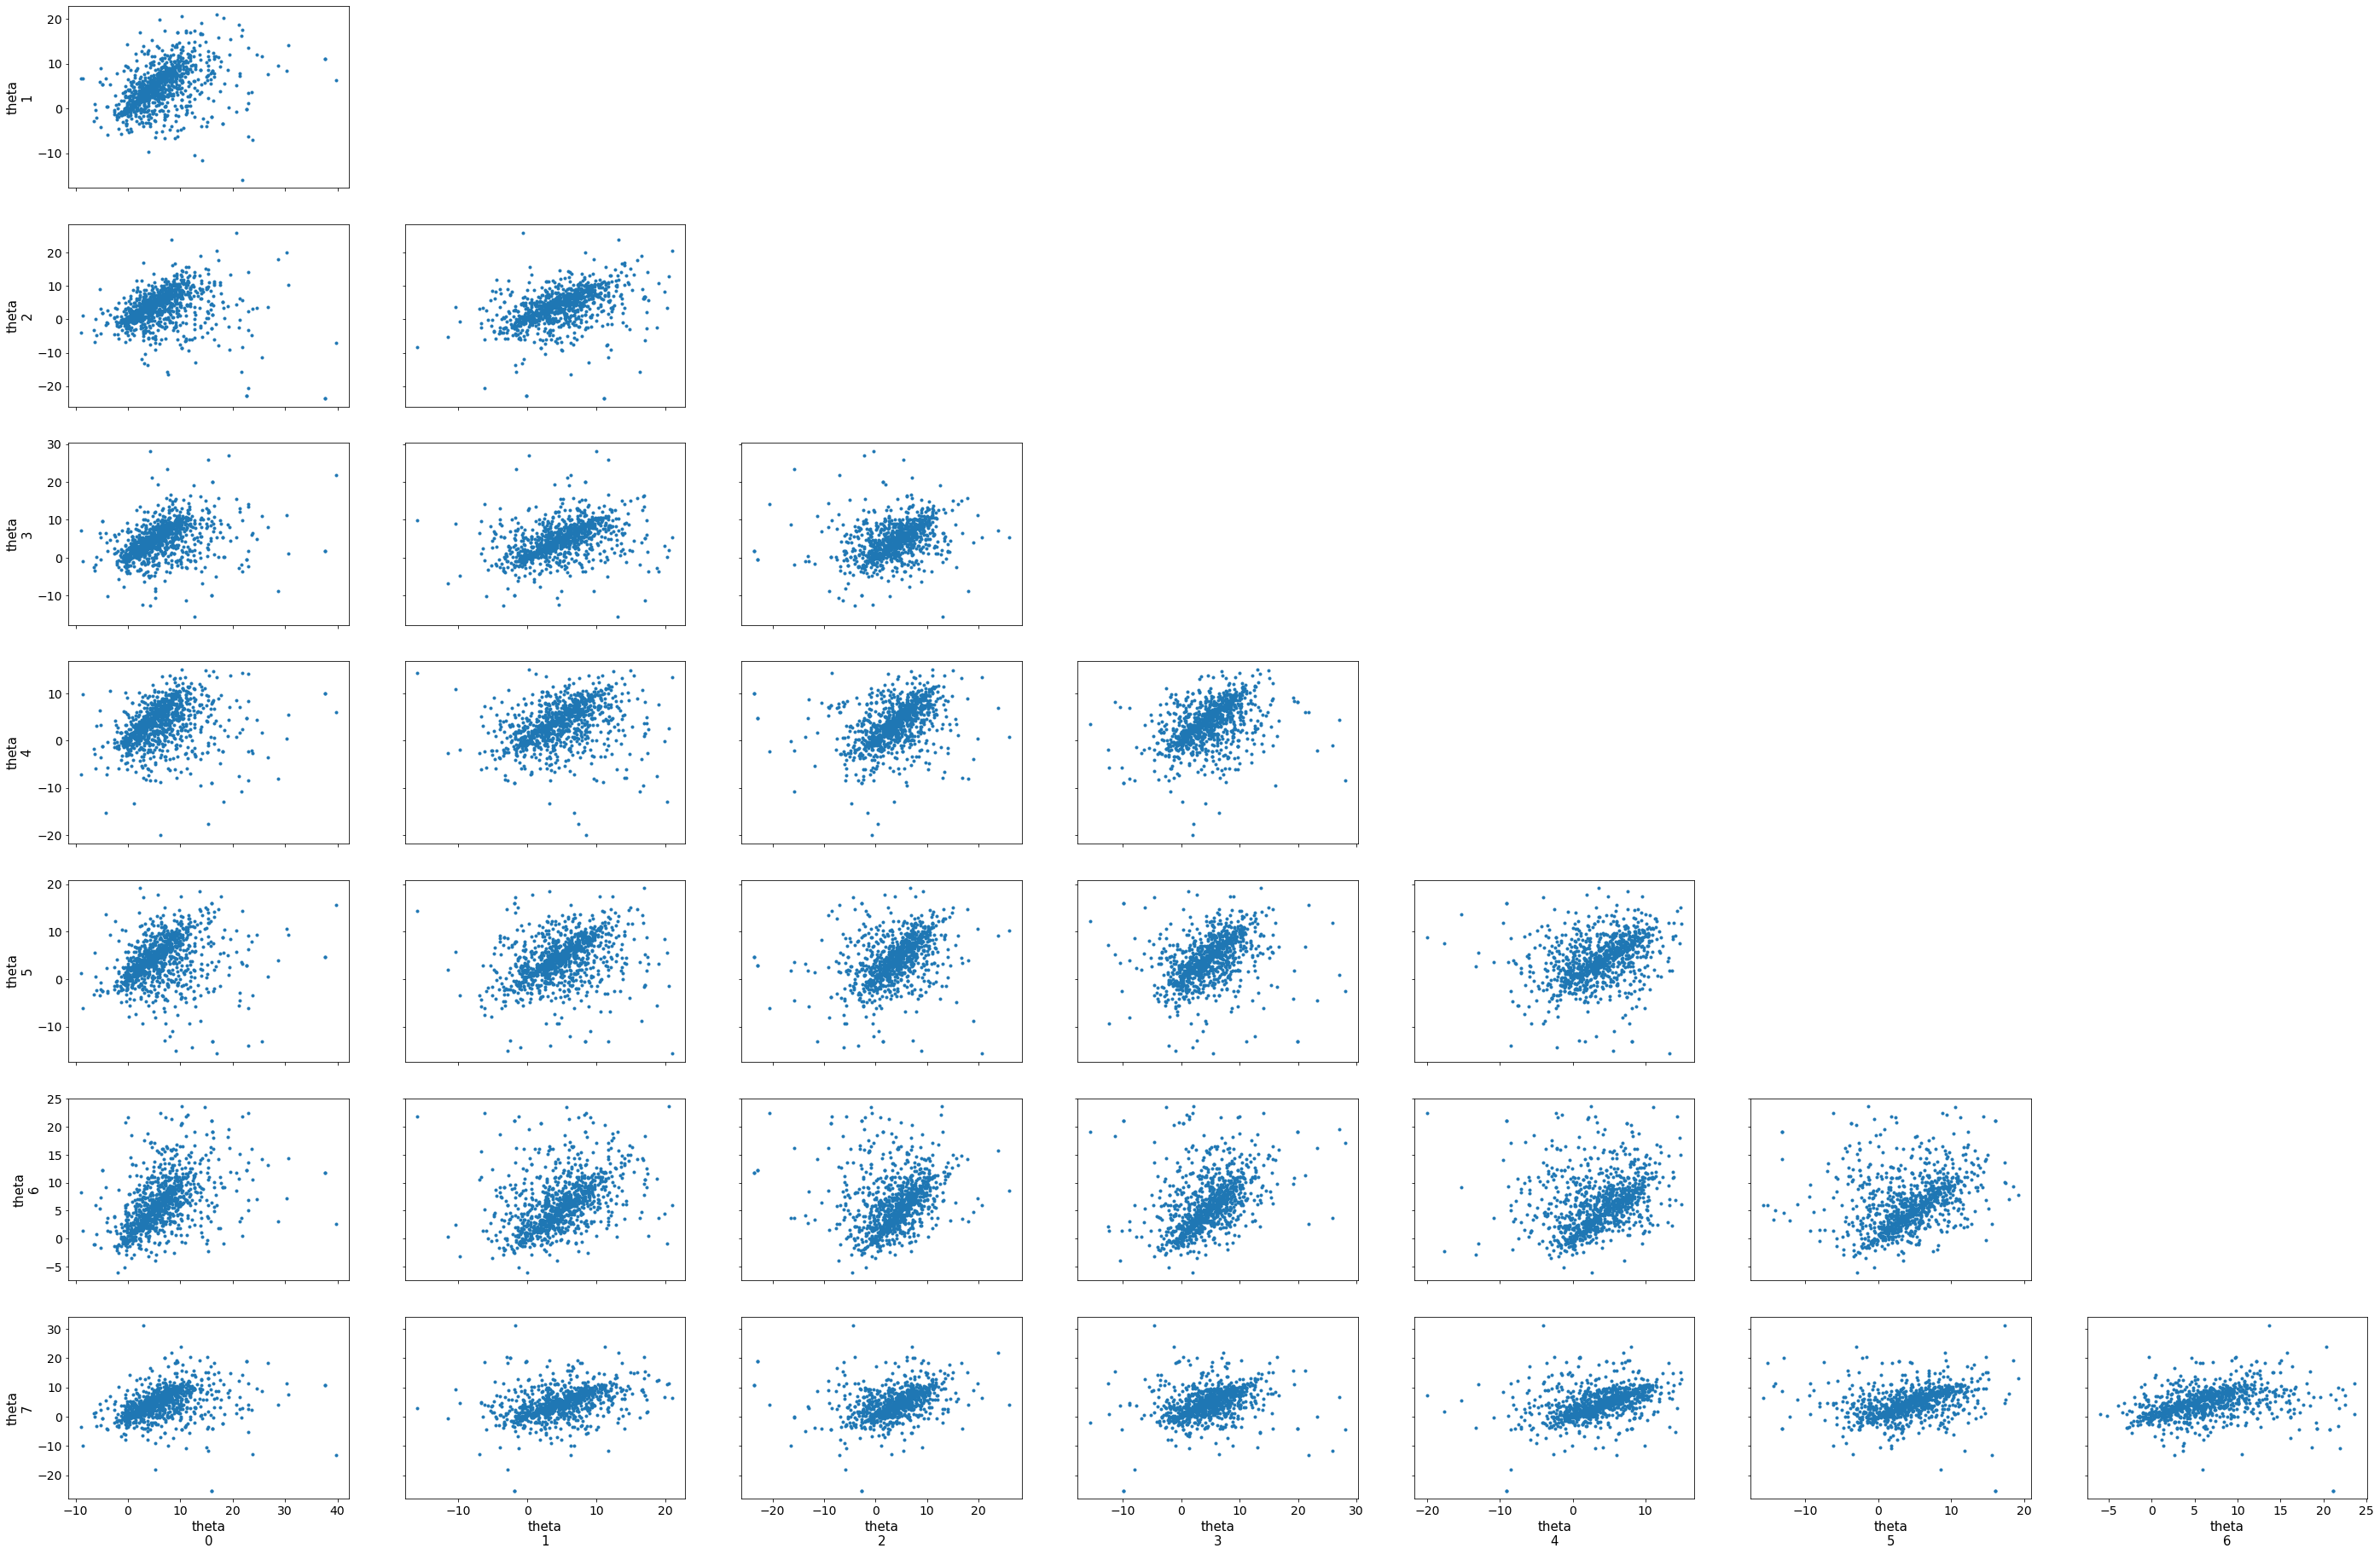

In [33]:
param_vars = ["theta"]

az.plot_pair(ds, var_names=param_vars, divergences=True)

array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'theta\n2'}>],
       [<AxesSubplot:title={'center':'theta\n3'}>,
        <AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>],
       [<AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>, <AxesSubplot:>]],
      dtype=object)

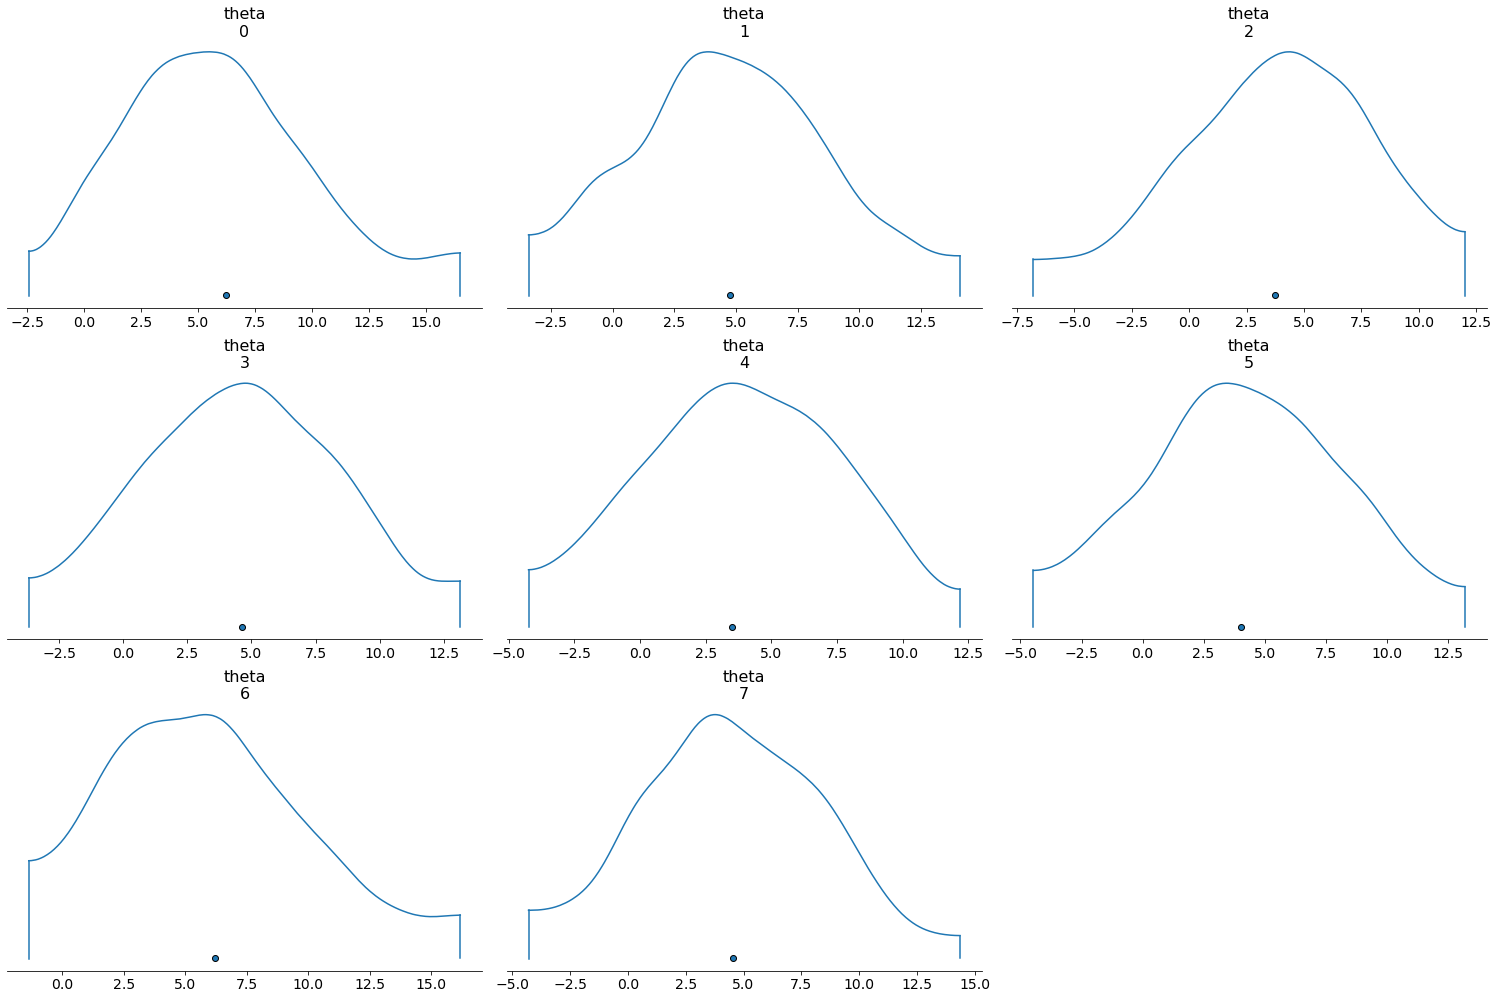

In [34]:
az.plot_density(ds.posterior, var_names=param_vars)